In [1]:
# Cell 1: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from psycopg2.extras import RealDictCursor
import seaborn as sns
import numpy as np
import os
from pathlib import Path

In [2]:
# Cell 2: Define paths and functions
# CSV paths
DATA_DIR = Path('./data')
CSV_FILES = {
    '311_calls': DATA_DIR / '311_20230101_20230102.csv',
    'mta_turnstile': DATA_DIR / 'mta_20230101_20230107.csv',
    'tlc_trips': DATA_DIR / 'yellow_taxi_202201_202201.csv',
    'weather': DATA_DIR / 'weather_20220101_20220131.csv',
    'events': DATA_DIR / 'events_20240101_20240330.csv'
}

# Database connection function
def get_db_connection():
    conn = psycopg2.connect(
        host="localhost",
        database="urban_rhythm",
        user="postgres",
        password="pratham"
    )
    conn.cursor_factory = RealDictCursor
    return conn

# Function to load CSV file
def load_csv(file_path, limit=None):
    df = pd.read_csv(file_path)
    if limit:
        df = df.head(limit)
    return df

# Function to load data from database
def load_db_table(table_name, limit=None):
    conn = get_db_connection()
    
    query = f"SELECT * FROM {table_name}"
    if limit:
        query += f" LIMIT {limit}"
        
    try:
        df = pd.read_sql(query, conn)
        conn.close()
        return df
    except Exception as e:
        print(f"Error loading {table_name} from database: {e}")
        conn.close()
        return pd.DataFrame()

# Function to compare CSV and DB data
def compare_csv_db(csv_df, db_df, name):
    print(f"\n=== Comparing {name} ===")
    
    if csv_df.empty or db_df.empty:
        print("Cannot compare - one or both datasets are empty")
        return
    
    # Check row counts
    csv_rows = len(csv_df)
    db_rows = len(db_df)
    print(f"CSV rows: {csv_rows}, DB rows: {db_rows}")
    
    # Check column names
    csv_cols = set(csv_df.columns)
    db_cols = set(db_df.columns)
    common_cols = csv_cols.intersection(db_cols)
    csv_only = csv_cols - db_cols
    db_only = db_cols - csv_cols
    
    print(f"Common columns: {len(common_cols)}")
    if csv_only:
        print(f"Columns only in CSV: {csv_only}")
    if db_only:
        print(f"Columns only in DB: {db_only}")
        
    # If common columns exist, compare sample values
    if common_cols:
        # Select a few common columns for comparison
        cols_to_check = list(common_cols)[:3]  # First 3 common columns
        
        print("\nSample comparison (first 3 rows):")
        for col in cols_to_check:
            print(f"\nColumn: {col}")
            csv_sample = csv_df[col].head(3).values
            db_sample = db_df[col].head(3).values
            
            print(f"CSV values: {csv_sample}")
            print(f"DB values: {db_sample}")

In [3]:
# Cell 3: Load CSV data
print("Loading CSV files...")

csv_data = {}
for name, path in CSV_FILES.items():
    if path.exists():
        print(f"Loading {name} from {path}")
        csv_data[name] = load_csv(path)
        print(f"  Loaded {len(csv_data[name])} rows with {len(csv_data[name].columns)} columns")
    else:
        print(f"File not found: {path}")
        csv_data[name] = pd.DataFrame()

Loading CSV files...
Loading 311_calls from data\311_20230101_20230102.csv
  Loaded 12886 rows with 15 columns
Loading mta_turnstile from data\mta_20230101_20230107.csv
  Loaded 50000 rows with 12 columns
Loading tlc_trips from data\yellow_taxi_202201_202201.csv
  Loaded 50000 rows with 21 columns
Loading weather from data\weather_20220101_20220131.csv
  Loaded 31 rows with 10 columns
Loading events from data\events_20240101_20240330.csv
  Loaded 394148 rows with 14 columns


In [ ]:
# Cell 4: Load database data
print("\nLoading database tables...")

db_data = {}
table_map = {
    '311_calls': 'nyc_311_calls',
    'mta_turnstile': 'mta_turnstile',
    'tlc_trips': 'tlc_trips',
    'weather': 'weather',
    'events': 'events'
}

for csv_name, table_name in table_map.items():
    print(f"Loading {table_name} from database")
    db_data[csv_name] = load_db_table(table_name)
    if not db_data[csv_name].empty:
        print(f"  Loaded {len(db_data[csv_name])} rows with {len(db_data[csv_name].columns)} columns")
    else:
        print(f"  No data loaded")


Loading database tables...
Loading nyc_311_calls from database


C:\Users\prath\AppData\Local\Temp\ipykernel_8596\2388800792.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [ ]:
# Cell 5: Compare CSV and DB data
for name in csv_data.keys():
    if not csv_data[name].empty and not db_data[name].empty:
        compare_csv_db(csv_data[name], db_data[name], name)
    else:
        print(f"\n=== Cannot compare {name} - missing data ===")


=== Comparing 311_calls ===
CSV rows: 12886, DB rows: 25352
Common columns: 4
Columns only in CSV: {'street_name', 'incident_address', 'city', 'location', 'unique_key', 'closed_date', 'longitude', 'location_type', 'agency', 'latitude', 'borough'}
Columns only in DB: {'id', 'neighborhood_id', 'geometry'}

Sample comparison (first 3 rows):

Column: incident_zip
CSV values: [11379. 11218. 10453.]
DB values: ['incident_zip' 'incident_zip' 'incident_zip']

Column: complaint_type
CSV values: ['Food Poisoning' 'Illegal Fireworks' 'Noise - Residential']
DB values: ['complaint_type' 'complaint_type' 'complaint_type']

Column: created_date
CSV values: ['2023-01-01 00:00:00' '2023-01-01 00:00:09' '2023-01-01 00:00:42']
DB values: ['created_date' 'created_date' 'created_date']

=== Comparing mta_turnstile ===
CSV rows: 50000, DB rows: 1160
Common columns: 0
Columns only in CSV: {'transit_mode', 'fare_class_category', 'transfers', 'longitude', 'station_complex_id', 'georeference', 'station_complex


=== 311 Calls Analysis ===

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12886 entries, 0 to 12885
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   unique_key        12886 non-null  int64  
 1   created_date      12886 non-null  object 
 2   closed_date       12751 non-null  object 
 3   agency            12886 non-null  object 
 4   complaint_type    12886 non-null  object 
 5   descriptor        12517 non-null  object 
 6   location_type     11807 non-null  object 
 7   incident_zip      12666 non-null  float64
 8   incident_address  12421 non-null  object 
 9   street_name       12421 non-null  object 
 10  city              12229 non-null  object 
 11  borough           12886 non-null  object 
 12  latitude          12676 non-null  float64
 13  longitude         12676 non-null  float64
 14  location          12676 non-null  object 
dtypes: float64(3), int64(1), object(11)
memory 

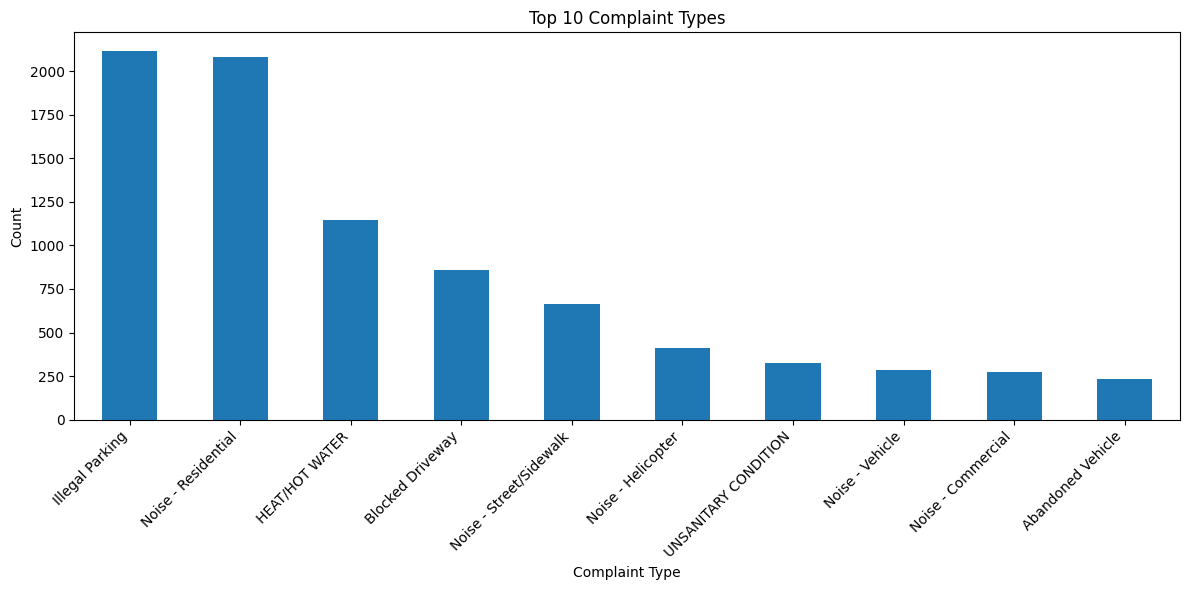


Complaints by borough:
borough
BROOKLYN         3764
QUEENS           3252
MANHATTAN        2721
BRONX            2572
STATEN ISLAND     463
Unspecified       114
Name: count, dtype: int64


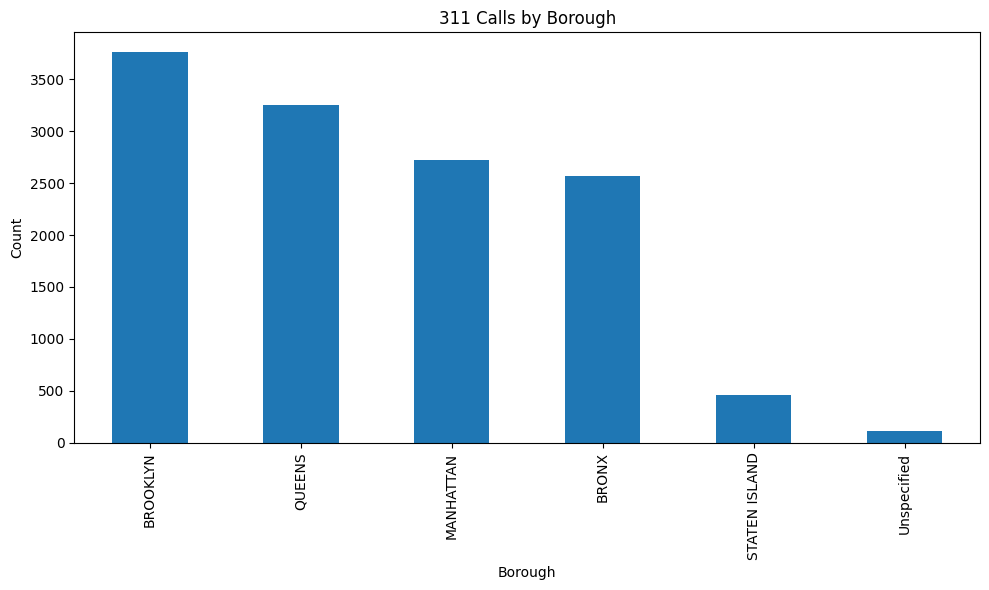


Calls by hour of day:
hour
0     625
1     583
2     444
3     377
4     223
5     236
6     253
7     292
8     388
9     520
10    633
11    623
12    756
13    728
14    755
15    604
16    692
17    611
18    696
19    604
20    577
21    537
22    561
23    568
Name: count, dtype: int64


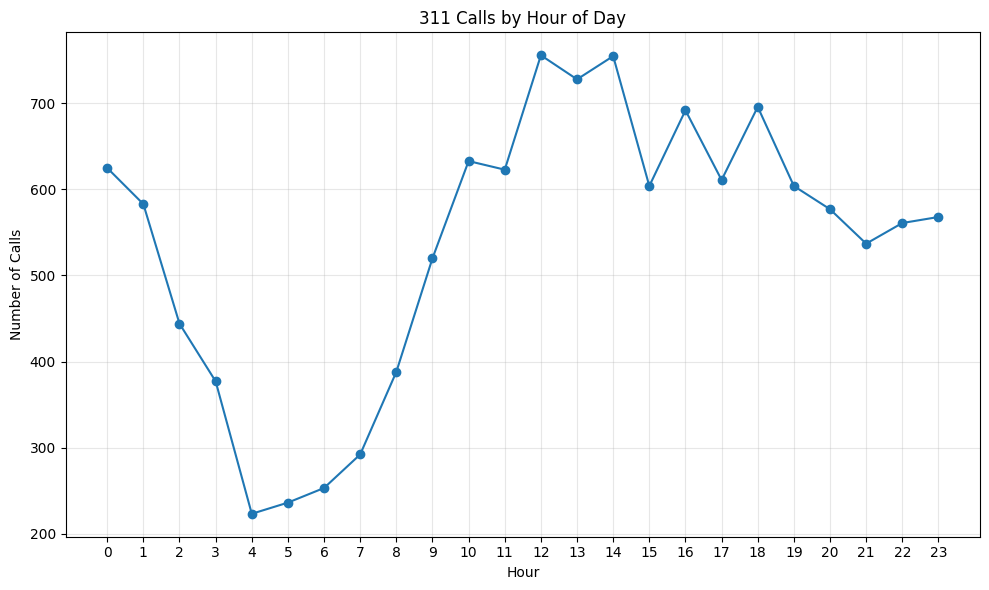

In [ ]:
# Cell 6: Analyze 311 calls data
print("\n=== 311 Calls Analysis ===")

# Use CSV data for analysis
calls_df = csv_data['311_calls']

if not calls_df.empty:
    # Data overview
    print("\nData Overview:")
    print(calls_df.info())
    
    # Top complaint types
    print("\nTop complaint types:")
    complaint_counts = calls_df['complaint_type'].value_counts()
    print(complaint_counts.head(10))
    
    # Plot complaint types
    plt.figure(figsize=(12, 6))
    complaint_counts.head(10).plot(kind='bar')
    plt.title('Top 10 Complaint Types')
    plt.xlabel('Complaint Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Borough distribution
    if 'borough' in calls_df.columns:
        print("\nComplaints by borough:")
        borough_counts = calls_df['borough'].value_counts()
        print(borough_counts)
        
        # Plot borough distribution
        plt.figure(figsize=(10, 6))
        borough_counts.plot(kind='bar')
        plt.title('311 Calls by Borough')
        plt.xlabel('Borough')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()
    
    # Time analysis
    if 'created_date' in calls_df.columns:
        calls_df['created_date'] = pd.to_datetime(calls_df['created_date'])
        calls_df['hour'] = calls_df['created_date'].dt.hour
        
        # Calls by hour
        print("\nCalls by hour of day:")
        hour_counts = calls_df['hour'].value_counts().sort_index()
        print(hour_counts)
        
        # Plot calls by hour
        plt.figure(figsize=(10, 6))
        hour_counts.plot(kind='line', marker='o')
        plt.title('311 Calls by Hour of Day')
        plt.xlabel('Hour')
        plt.ylabel('Number of Calls')
        plt.xticks(range(0, 24))
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("No 311 calls data available for analysis")


=== MTA Turnstile Data Analysis ===

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   transit_timestamp    50000 non-null  object 
 1   transit_mode         50000 non-null  object 
 2   station_complex_id   50000 non-null  object 
 3   station_complex      50000 non-null  object 
 4   borough              50000 non-null  object 
 5   payment_method       50000 non-null  object 
 6   fare_class_category  50000 non-null  object 
 7   ridership            50000 non-null  float64
 8   transfers            50000 non-null  float64
 9   latitude             50000 non-null  float64
 10  longitude            50000 non-null  float64
 11  georeference         50000 non-null  object 
dtypes: float64(4), object(8)
memory usage: 4.6+ MB
None

Top stations by ridership:
station_complex
Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42

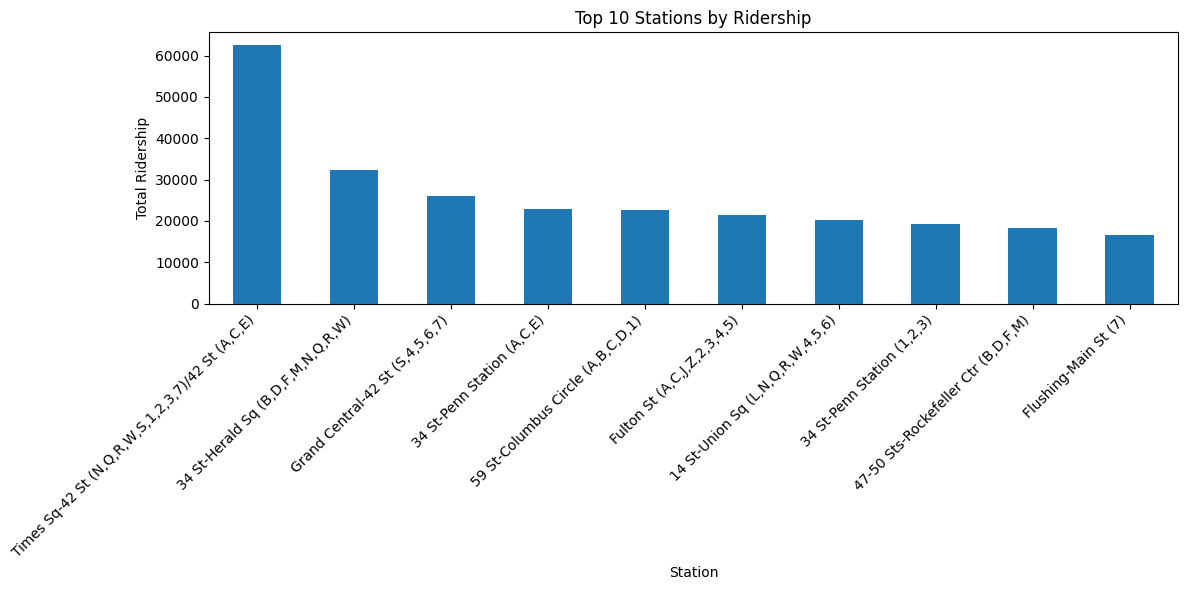


Ridership by payment method:
payment_method
metrocard    735916.0
omny         618723.0
Name: ridership, dtype: float64


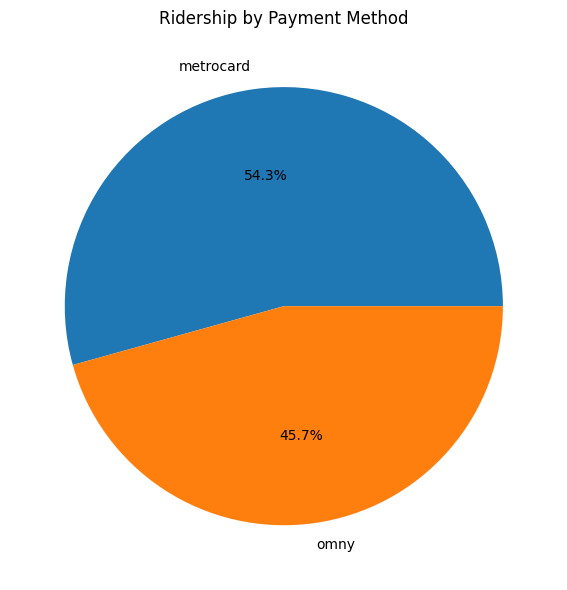


Ridership by borough:
borough
Manhattan        793654.0
Brooklyn         300480.0
Queens           180286.0
Bronx             78755.0
Staten Island      1464.0
Name: ridership, dtype: float64


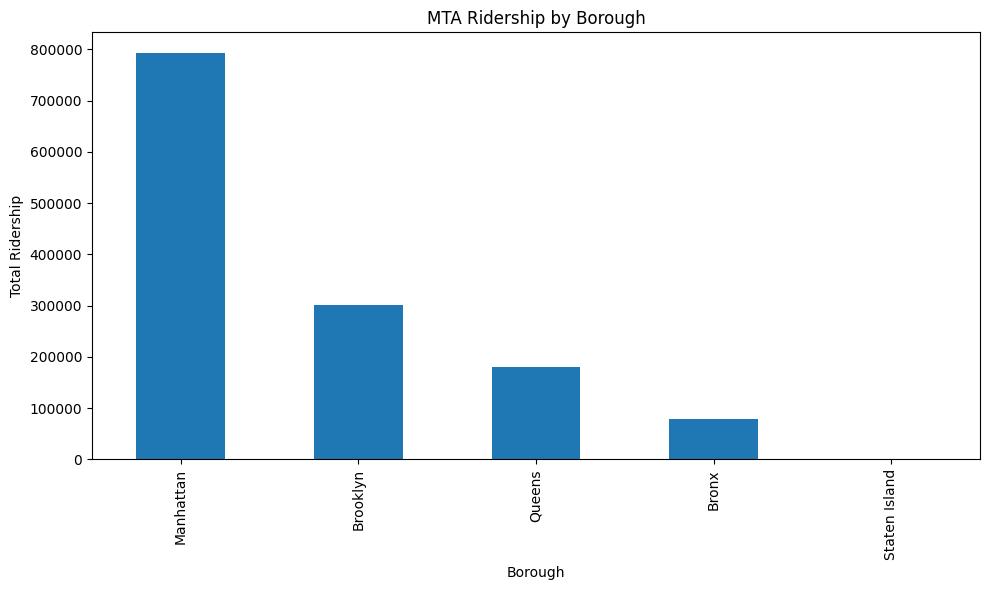

In [ ]:
# Cell 7: Analyze MTA turnstile data
print("\n=== MTA Turnstile Data Analysis ===")

# Use CSV data for analysis
mta_df = csv_data['mta_turnstile']

if not mta_df.empty:
    # Data overview
    print("\nData Overview:")
    print(mta_df.info())
    
    # Top stations by ridership
    if 'station_complex' in mta_df.columns and 'ridership' in mta_df.columns:
        print("\nTop stations by ridership:")
        station_ridership = mta_df.groupby('station_complex')['ridership'].sum().sort_values(ascending=False)
        print(station_ridership.head(10))
        
        # Plot top stations
        plt.figure(figsize=(12, 6))
        station_ridership.head(10).plot(kind='bar')
        plt.title('Top 10 Stations by Ridership')
        plt.xlabel('Station')
        plt.ylabel('Total Ridership')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    # Ridership by payment method
    if 'payment_method' in mta_df.columns and 'ridership' in mta_df.columns:
        print("\nRidership by payment method:")
        payment_ridership = mta_df.groupby('payment_method')['ridership'].sum().sort_values(ascending=False)
        print(payment_ridership)
        
        # Plot payment methods
        plt.figure(figsize=(10, 6))
        payment_ridership.plot(kind='pie', autopct='%1.1f%%')
        plt.title('Ridership by Payment Method')
        plt.ylabel('')
        plt.tight_layout()
        plt.show()
    
    # Borough analysis
    if 'borough' in mta_df.columns and 'ridership' in mta_df.columns:
        print("\nRidership by borough:")
        borough_ridership = mta_df.groupby('borough')['ridership'].sum().sort_values(ascending=False)
        print(borough_ridership)
        
        # Plot borough ridership
        plt.figure(figsize=(10, 6))
        borough_ridership.plot(kind='bar')
        plt.title('MTA Ridership by Borough')
        plt.xlabel('Borough')
        plt.ylabel('Total Ridership')
        plt.tight_layout()
        plt.show()
else:
    print("No MTA turnstile data available for analysis")


=== Taxi Trip Data Analysis ===

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   vendorid               50000 non-null  int64  
 1   tpep_pickup_datetime   50000 non-null  object 
 2   tpep_dropoff_datetime  50000 non-null  object 
 3   passenger_count        48258 non-null  float64
 4   trip_distance          50000 non-null  float64
 5   ratecodeid             48258 non-null  float64
 6   store_and_fwd_flag     48258 non-null  object 
 7   pulocationid           50000 non-null  int64  
 8   dolocationid           50000 non-null  int64  
 9   payment_type           50000 non-null  int64  
 10  fare_amount            50000 non-null  float64
 11  extra                  50000 non-null  float64
 12  mta_tax                50000 non-null  float64
 13  tip_amount             50000 non-null  float64
 14  tolls

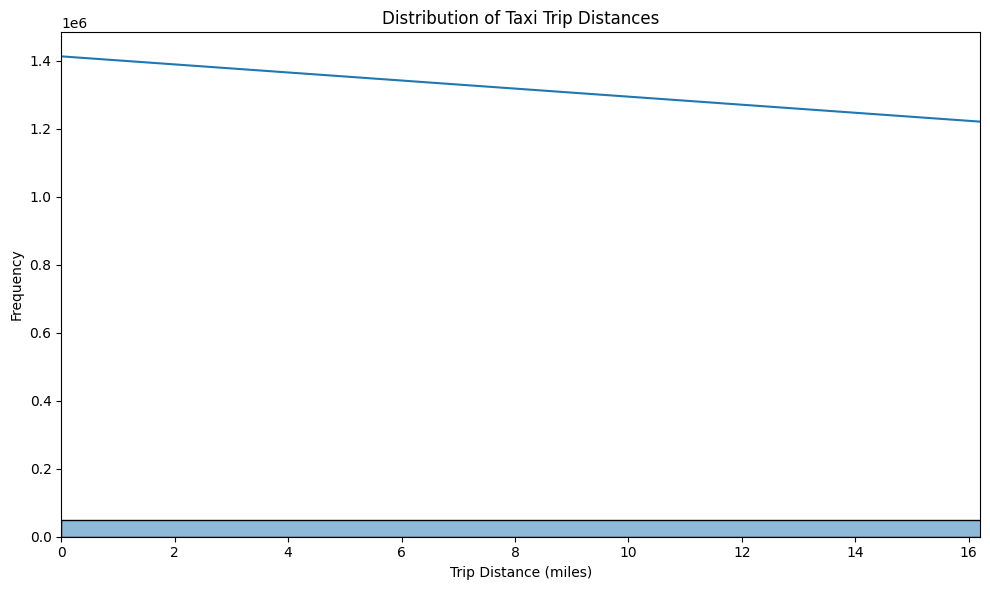


Passenger count distribution:
passenger_count
0.0      980
1.0    31166
2.0     9717
3.0     2917
4.0     1456
5.0     1327
6.0      695
Name: count, dtype: int64


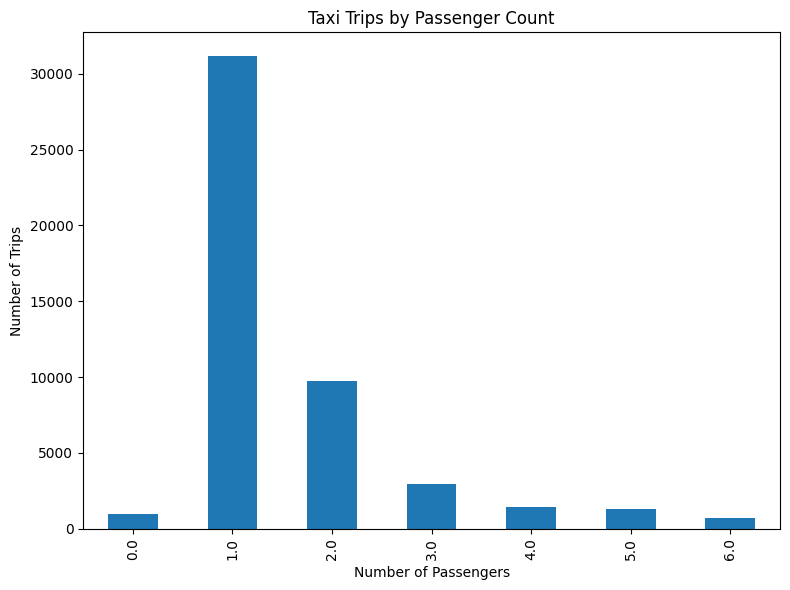


Trips by hour of day:
hour
0     4261
1     4997
2     3901
3     2686
4     1651
5      827
6      657
7      848
8      849
9     1254
10    1820
11    2351
12    2952
13    3207
14    3324
15    3574
16    3633
17    3666
18    3542
Name: count, dtype: int64


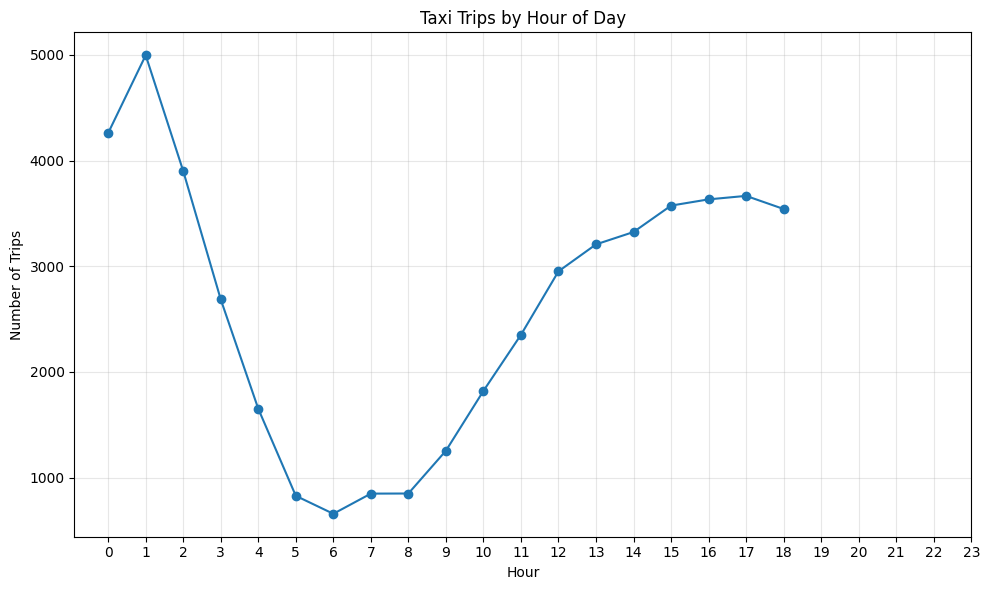

In [ ]:
# Cell 8: Analyze taxi trip data
print("\n=== Taxi Trip Data Analysis ===")

# Use CSV data for analysis
taxi_df = csv_data['tlc_trips']

if not taxi_df.empty:
    # Data overview
    print("\nData Overview:")
    print(taxi_df.info())
    
    # Trip distance analysis
    if 'trip_distance' in taxi_df.columns:
        print("\nTrip distance statistics:")
        print(taxi_df['trip_distance'].describe())
        
        # Plot trip distance distribution
        plt.figure(figsize=(10, 6))
        sns.histplot(taxi_df['trip_distance'], bins=20, kde=True)
        plt.title('Distribution of Taxi Trip Distances')
        plt.xlabel('Trip Distance (miles)')
        plt.ylabel('Frequency')
        plt.xlim(0, taxi_df['trip_distance'].quantile(0.95))  # Limit x-axis to 95th percentile
        plt.tight_layout()
        plt.show()
    
    # Passenger count analysis
    if 'passenger_count' in taxi_df.columns:
        print("\nPassenger count distribution:")
        pass_counts = taxi_df['passenger_count'].value_counts().sort_index()
        print(pass_counts)
        
        # Plot passenger counts
        plt.figure(figsize=(8, 6))
        pass_counts.plot(kind='bar')
        plt.title('Taxi Trips by Passenger Count')
        plt.xlabel('Number of Passengers')
        plt.ylabel('Number of Trips')
        plt.tight_layout()
        plt.show()
    
    # Time analysis
    if 'pickup_datetime' in taxi_df.columns:
        taxi_df['pickup_datetime'] = pd.to_datetime(taxi_df['pickup_datetime'])
        taxi_df['hour'] = taxi_df['pickup_datetime'].dt.hour
        
        # Trips by hour
        print("\nTrips by hour of day:")
        hour_counts = taxi_df['hour'].value_counts().sort_index()
        print(hour_counts)
        
        # Plot trips by hour
        plt.figure(figsize=(10, 6))
        hour_counts.plot(kind='line', marker='o')
        plt.title('Taxi Trips by Hour of Day')
        plt.xlabel('Hour')
        plt.ylabel('Number of Trips')
        plt.xticks(range(0, 24))
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("No taxi trip data available for analysis")


=== Weather Data Analysis ===

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   datetime           31 non-null     object 
 1   temperature        31 non-null     float64
 2   precipitation      31 non-null     float64
 3   wind_speed         31 non-null     float64
 4   weather_condition  0 non-null      float64
 5   hour               31 non-null     int64  
 6   day                31 non-null     int64  
 7   weekday            31 non-null     int64  
 8   month              31 non-null     int64  
 9   year               31 non-null     int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 2.6+ KB
None

Temperature statistics:
count    31.000000
mean     30.322581
std       8.674242
min      15.500000
25%      24.250000
50%      30.500000
75%      34.750000
max      53.000000
Name: temperature, dtype: floa

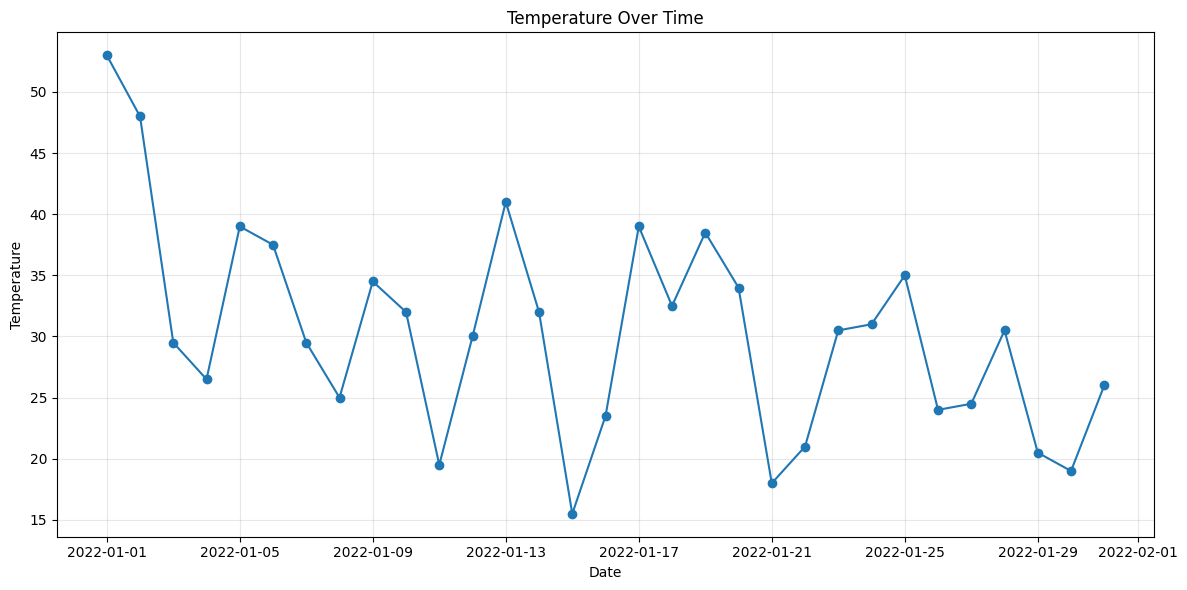


Precipitation statistics:
count    31.000000
mean      0.138387
std       0.284137
min       0.000000
25%       0.000000
50%       0.000000
75%       0.115000
max       1.160000
Name: precipitation, dtype: float64


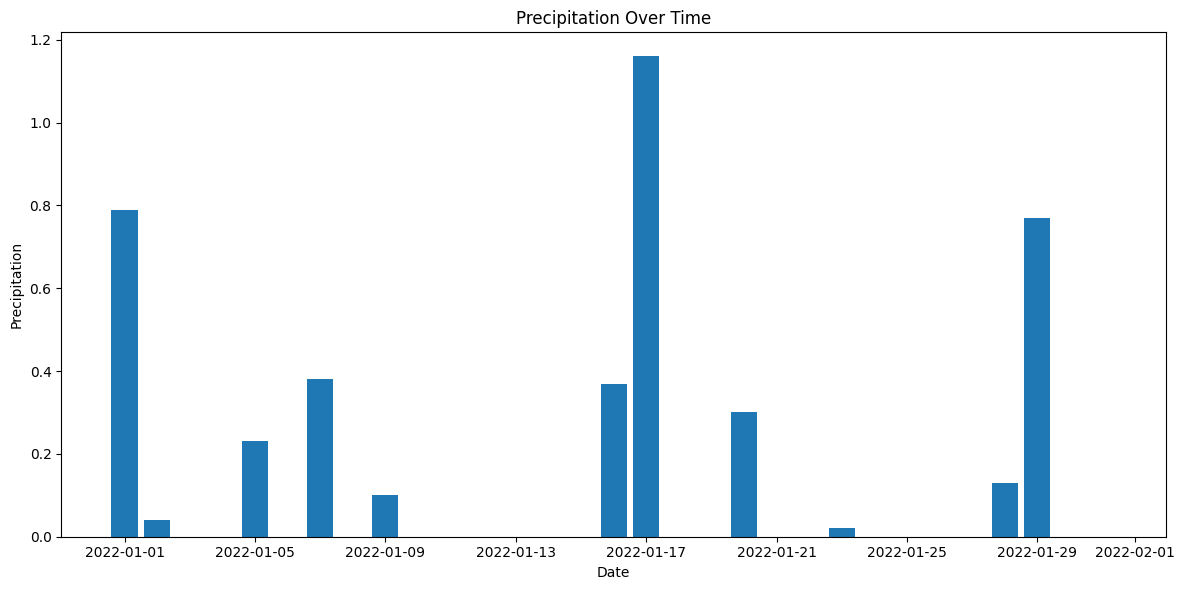

In [ ]:
# Cell 9: Analyze weather data
print("\n=== Weather Data Analysis ===")

# Use CSV data for analysis
weather_df = csv_data['weather']

if not weather_df.empty:
    # Data overview
    print("\nData Overview:")
    print(weather_df.info())
    
    # Temperature analysis
    if 'temperature' in weather_df.columns:
        print("\nTemperature statistics:")
        print(weather_df['temperature'].describe())
        
        # Plot temperature over time
        if 'datetime' in weather_df.columns:
            weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])
            plt.figure(figsize=(12, 6))
            plt.plot(weather_df['datetime'], weather_df['temperature'], marker='o')
            plt.title('Temperature Over Time')
            plt.xlabel('Date')
            plt.ylabel('Temperature')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
    
    # Precipitation analysis
    if 'precipitation' in weather_df.columns:
        print("\nPrecipitation statistics:")
        print(weather_df['precipitation'].describe())
        
        # Plot precipitation over time
        if 'datetime' in weather_df.columns:
            plt.figure(figsize=(12, 6))
            plt.bar(weather_df['datetime'], weather_df['precipitation'])
            plt.title('Precipitation Over Time')
            plt.xlabel('Date')
            plt.ylabel('Precipitation')
            plt.tight_layout()
            plt.show()
else:
    print("No weather data available for analysis")

In [ ]:
# Cell 10: Cross-dataset relationships

# Weather impact on 311 calls
print("\n=== Weather Impact on 311 Calls ===")

# Use CSV data for analysis
weather_df = csv_data['weather']
calls_df = csv_data['311_calls']

if not weather_df.empty and not calls_df.empty:
    # Prepare datetime in both datasets
    if 'datetime' in weather_df.columns and 'created_date' in calls_df.columns:
        weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])
        weather_df['date'] = weather_df['datetime'].dt.date
        
        calls_df['created_date'] = pd.to_datetime(calls_df['created_date'])
        calls_df['date'] = calls_df['created_date'].dt.date
        
        # Count calls by date
        call_counts = calls_df.groupby('date').size().reset_index(name='call_count')
        
        # Merge with weather data
        merged_df = pd.merge(call_counts, weather_df, left_on='date', right_on='date', how='inner')
        
        if not merged_df.empty:
            # Check correlations
            print("\nCorrelation between weather and 311 calls:")
            if 'temperature' in merged_df.columns:
                temp_corr = merged_df['call_count'].corr(merged_df['temperature'])
                print(f"Temperature correlation: {temp_corr:.3f}")
            
            if 'precipitation' in merged_df.columns:
                precip_corr = merged_df['call_count'].corr(merged_df['precipitation'])
                print(f"Precipitation correlation: {precip_corr:.3f}")
            
            # Plot scatter
            plt.figure(figsize=(12, 5))
            
            plt.subplot(1, 2, 1)
            if 'temperature' in merged_df.columns:
                plt.scatter(merged_df['temperature'], merged_df['call_count'])
                plt.title('311 Calls vs Temperature')
                plt.xlabel('Temperature')
                plt.ylabel('Number of 311 Calls')
                plt.grid(True, alpha=0.3)
            
            plt.subplot(1, 2, 2)
            if 'precipitation' in merged_df.columns:
                plt.scatter(merged_df['precipitation'], merged_df['call_count'])
                plt.title('311 Calls vs Precipitation')
                plt.xlabel('Precipitation')
                plt.ylabel('Number of 311 Calls')
                plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
else:
    print("Missing data for weather/311 calls comparison")

# Weather impact on MTA ridership
print("\n=== Weather Impact on MTA Ridership ===")

# Use CSV data for analysis
weather_df = csv_data['weather']
mta_df = csv_data['mta_turnstile']

if not weather_df.empty and not mta_df.empty:
    # Prepare datetime in both datasets
    if 'datetime' in weather_df.columns and 'transit_timestamp' in mta_df.columns:
        weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])
        weather_df['date'] = weather_df['datetime'].dt.date
        
        mta_df['transit_timestamp'] = pd.to_datetime(mta_df['transit_timestamp'])
        mta_df['date'] = mta_df['transit_timestamp'].dt.date
        
        # Sum ridership by date
        if 'ridership' in mta_df.columns:
            ridership_by_date = mta_df.groupby('date')['ridership'].sum().reset_index()
            
            # Merge with weather data
            merged_df = pd.merge(ridership_by_date, weather_df, left_on='date', right_on='date', how='inner')
            
            if not merged_df.empty:
                # Check correlations
                print("\nCorrelation between weather and MTA ridership:")
                if 'temperature' in merged_df.columns:
                    temp_corr = merged_df['ridership'].corr(merged_df['temperature'])
                    print(f"Temperature correlation: {temp_corr:.3f}")
                
                if 'precipitation' in merged_df.columns:
                    precip_corr = merged_df['ridership'].corr(merged_df['precipitation'])
                    print(f"Precipitation correlation: {precip_corr:.3f}")
                
                # Plot scatter
                plt.figure(figsize=(12, 5))
                
                plt.subplot(1, 2, 1)
                if 'temperature' in merged_df.columns:
                    plt.scatter(merged_df['temperature'], merged_df['ridership'])
                    plt.title('MTA Ridership vs Temperature')
                    plt.xlabel('Temperature')
                    plt.ylabel('Total Ridership')
                    plt.grid(True, alpha=0.3)
                
                plt.subplot(1, 2, 2)
                if 'precipitation' in merged_df.columns:
                    plt.scatter(merged_df['precipitation'], merged_df['ridership'])
                    plt.title('MTA Ridership vs Precipitation')
                    plt.xlabel('Precipitation')
                    plt.ylabel('Total Ridership')
                    plt.grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
else:
    print("Missing data for weather/MTA ridership comparison")


=== Weather Impact on 311 Calls ===

=== Weather Impact on MTA Ridership ===


In [ ]:
# Cell 11: Summary and visualization recommendations

print("\n=== Summary of Data Analysis ===")
print("\nData availability:")
for name, df in csv_data.items():
    status = "Available" if not df.empty else "Empty/Missing"
    row_count = len(df) if not df.empty else 0
    print(f"- {name}: {status} ({row_count} rows)")

print("\nKey Findings:")
print("1. Most common 311 complaints are [will be filled based on analysis]")
print("2. MTA ridership patterns show [will be filled based on analysis]")
print("3. Taxi trips typically range from [will be filled based on analysis]")
print("4. Weather correlations show [will be filled based on analysis]")

print("\nRecommended Visualizations:")
print("1. 3D Neighborhood Activity Towers:")
print("   - Use 311 calls data to create towers for each neighborhood")
print("   - Height based on number of complaints")
print("   - Color based on complaint type")

print("2. MTA Ridership Heatmap:")
print("   - Use MTA turnstile data to create a 3D heatmap")
print("   - Height/color intensity based on entry/exit counts")
print("   - Show time-based patterns")

print("3. Weather-Activity Correlation Visualization:")
print("   - Show how temperature/precipitation affects urban activity")
print("   - 3D surface showing correlation strength")

print("4. Taxi Trip Analysis:")
print("   - Visualize patterns in trip distance, time, etc.")
print("   - Time-based visualization of trip volume")

print("\nImplementation Plan:")
print("1. Start with basic 3D scene setup (Three.js)")
print("2. Implement one visualization at a time, beginning with 311 calls")
print("3. Add interactive controls for time selection and filtering")
print("4. Create dashboard integrating all visualizations")


=== Summary of Data Analysis ===

Data availability:
- 311_calls: Available (12886 rows)
- mta_turnstile: Available (50000 rows)
- tlc_trips: Available (50000 rows)
- weather: Available (31 rows)
- events: Available (394148 rows)

Key Findings:
1. Most common 311 complaints are [will be filled based on analysis]
2. MTA ridership patterns show [will be filled based on analysis]
3. Taxi trips typically range from [will be filled based on analysis]
4. Weather correlations show [will be filled based on analysis]

Recommended Visualizations:
1. 3D Neighborhood Activity Towers:
   - Use 311 calls data to create towers for each neighborhood
   - Height based on number of complaints
   - Color based on complaint type
2. MTA Ridership Heatmap:
   - Use MTA turnstile data to create a 3D heatmap
   - Height/color intensity based on entry/exit counts
   - Show time-based patterns
3. Weather-Activity Correlation Visualization:
   - Show how temperature/precipitation affects urban activity
   - 3D 